In [1]:
!pip install gtts

In [2]:
import os
import random
import pickle
import warnings
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Bidirectional, BatchNormalization, RepeatVector, Dot, Activation, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Add
import matplotlib.image as mpimg
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import History
from nltk.translate.bleu_score import corpus_bleu
warnings.filterwarnings("ignore", category=FutureWarning)
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from gtts import gTTS
from IPython.display import Audio, display


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
BASE_DIR = '/kaggle/input/flickr30k'
WORKING_DIR = '/kaggle/working'


# Caption Preprocessing:

In [4]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)


def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

clean(mapping)


100%|██████████| 158916/158916 [00:00<00:00, 708350.26it/s]


In [5]:
example_keys = list(mapping.keys())[:2]  
for key in example_keys:
    print(f"Image ID: {key}")
    for caption in mapping[key]:
        print(f"Cleaned Caption: {caption}")
    print("-" * 50)  


Image ID: 1000092795
Cleaned Caption: startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq
Cleaned Caption: startseq two young white males are outside near many bushes ." endseq
Cleaned Caption: startseq two men in green shirts are standing in yard endseq
Cleaned Caption: startseq man in blue shirt standing in garden endseq
Cleaned Caption: startseq two friends enjoy time spent together endseq
--------------------------------------------------
Image ID: 10002456
Cleaned Caption: startseq several men in hard hats are operating giant pulley system endseq
Cleaned Caption: startseq workers look down from up above on piece of equipment endseq
Cleaned Caption: startseq two men working on machine wearing hard hats endseq
Cleaned Caption: startseq four men on top of tall structure endseq
Cleaned Caption: startseq three men on large rig endseq
--------------------------------------------------


# Text Tokenization:

In [6]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

pickle.dump(tokenizer, open(os.path.join(WORKING_DIR, 'tokenizerf.pkl'), 'wb'))


In [7]:
len(all_captions)


158915

In [8]:
vocab_size


18314

# Splitting Dataset:

In [9]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

print("Number of training samples:", len(train))
print("Number of testing samples:", len(test))

max_length = max(len(caption.split()) for caption in all_captions)
print("Maximum Caption Length:",(max_length))


Number of training samples: 28604
Number of testing samples: 3179
Maximum Caption Length: 75


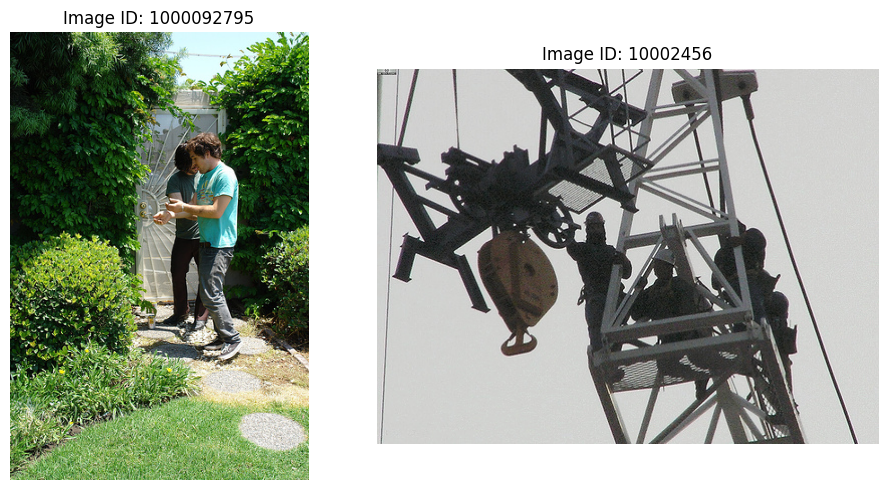

In [10]:
IMAGES_DIR = os.path.join(BASE_DIR, 'Images', 'flickr30k_images')

image_files = list(mapping.keys())[:2]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  

for i, image_id in enumerate(image_files):
    image_path = os.path.join(IMAGES_DIR, image_id + '.jpg')  
    if os.path.exists(image_path): 
        img = mpimg.imread(image_path)
        axes[i].imshow(img) 
        axes[i].set_title(f"Image ID: {image_id}")
        axes[i].axis('off')  
    else:
        print(f"Image {image_id}.jpg not found in the dataset.")

plt.tight_layout() 
plt.show()


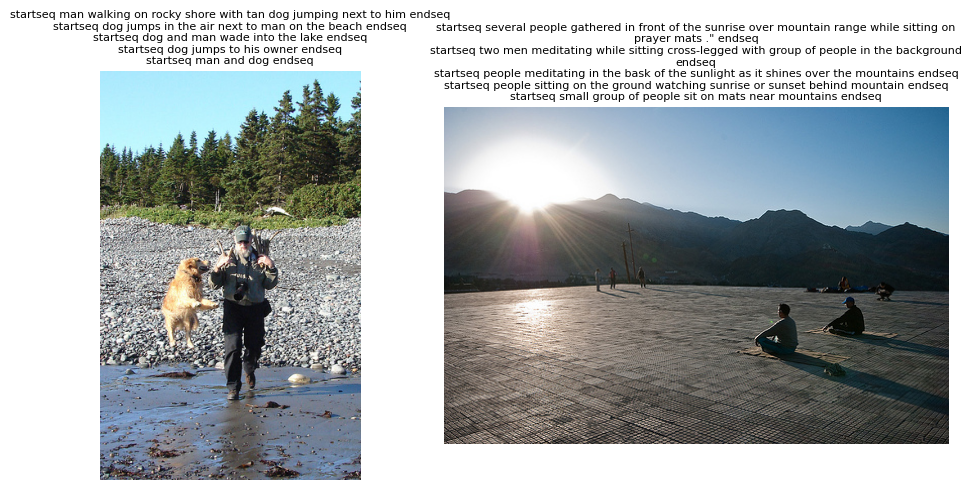

In [11]:
def display_random_images(directory, mapping, num_images=2):
   
    image_ids = random.sample(list(mapping.keys()), num_images)
    fig, axes = plt.subplots(1, num_images, figsize=(10, 5))
    
    for i, image_id in enumerate(image_ids):
        img_path = os.path.join(directory, image_id + '.jpg') 
        
        if os.path.exists(img_path):
            img = mpimg.imread(img_path)
            
            axes[i].imshow(img)
            axes[i].axis('off')  
            
            captions = mapping[image_id]
            caption_text = "\n".join(captions)
            axes[i].set_title(caption_text, fontsize=8, wrap=True)
        else:
            axes[i].axis('off')  
            axes[i].set_title(f"Image {image_id}.jpg not found.", fontsize=12)
    
    plt.tight_layout()
    plt.show()


image_directory = os.path.join(BASE_DIR, 'Images', 'flickr30k_images')
display_random_images(image_directory, mapping)


So, here we are done with Captions:
1. Mapping
2. Cleaning
3. Tokenizing 

# MODEL:

# ResNet50

In [12]:
resnet_model = ResNet50(weights='imagenet')
model = Model(inputs=resnet_model.inputs, outputs=resnet_model.layers[-2].output)
print(model.summary())

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

None


In [13]:
features3 = {}
directory = os.path.join(BASE_DIR, 'Images', 'flickr30k_images')

for img_name in tqdm(os.listdir(directory)):
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)  
    feature3 = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features3[image_id] = feature3


  0%|          | 0/31783 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1733213960.492919      79 service.cc:145] XLA service 0x78b7a0045470 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733213960.492972      79 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733213960.492976      79 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1733213963.512252      79 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 31783/31783 [41:38<00:00, 12.72it/s]


In [14]:

pickle.dump(features3, open(os.path.join(WORKING_DIR, 'features_resnet50f.pkl'), 'wb'))


In [15]:
def data_generator3(data_keys, mapping, features3, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features3[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0


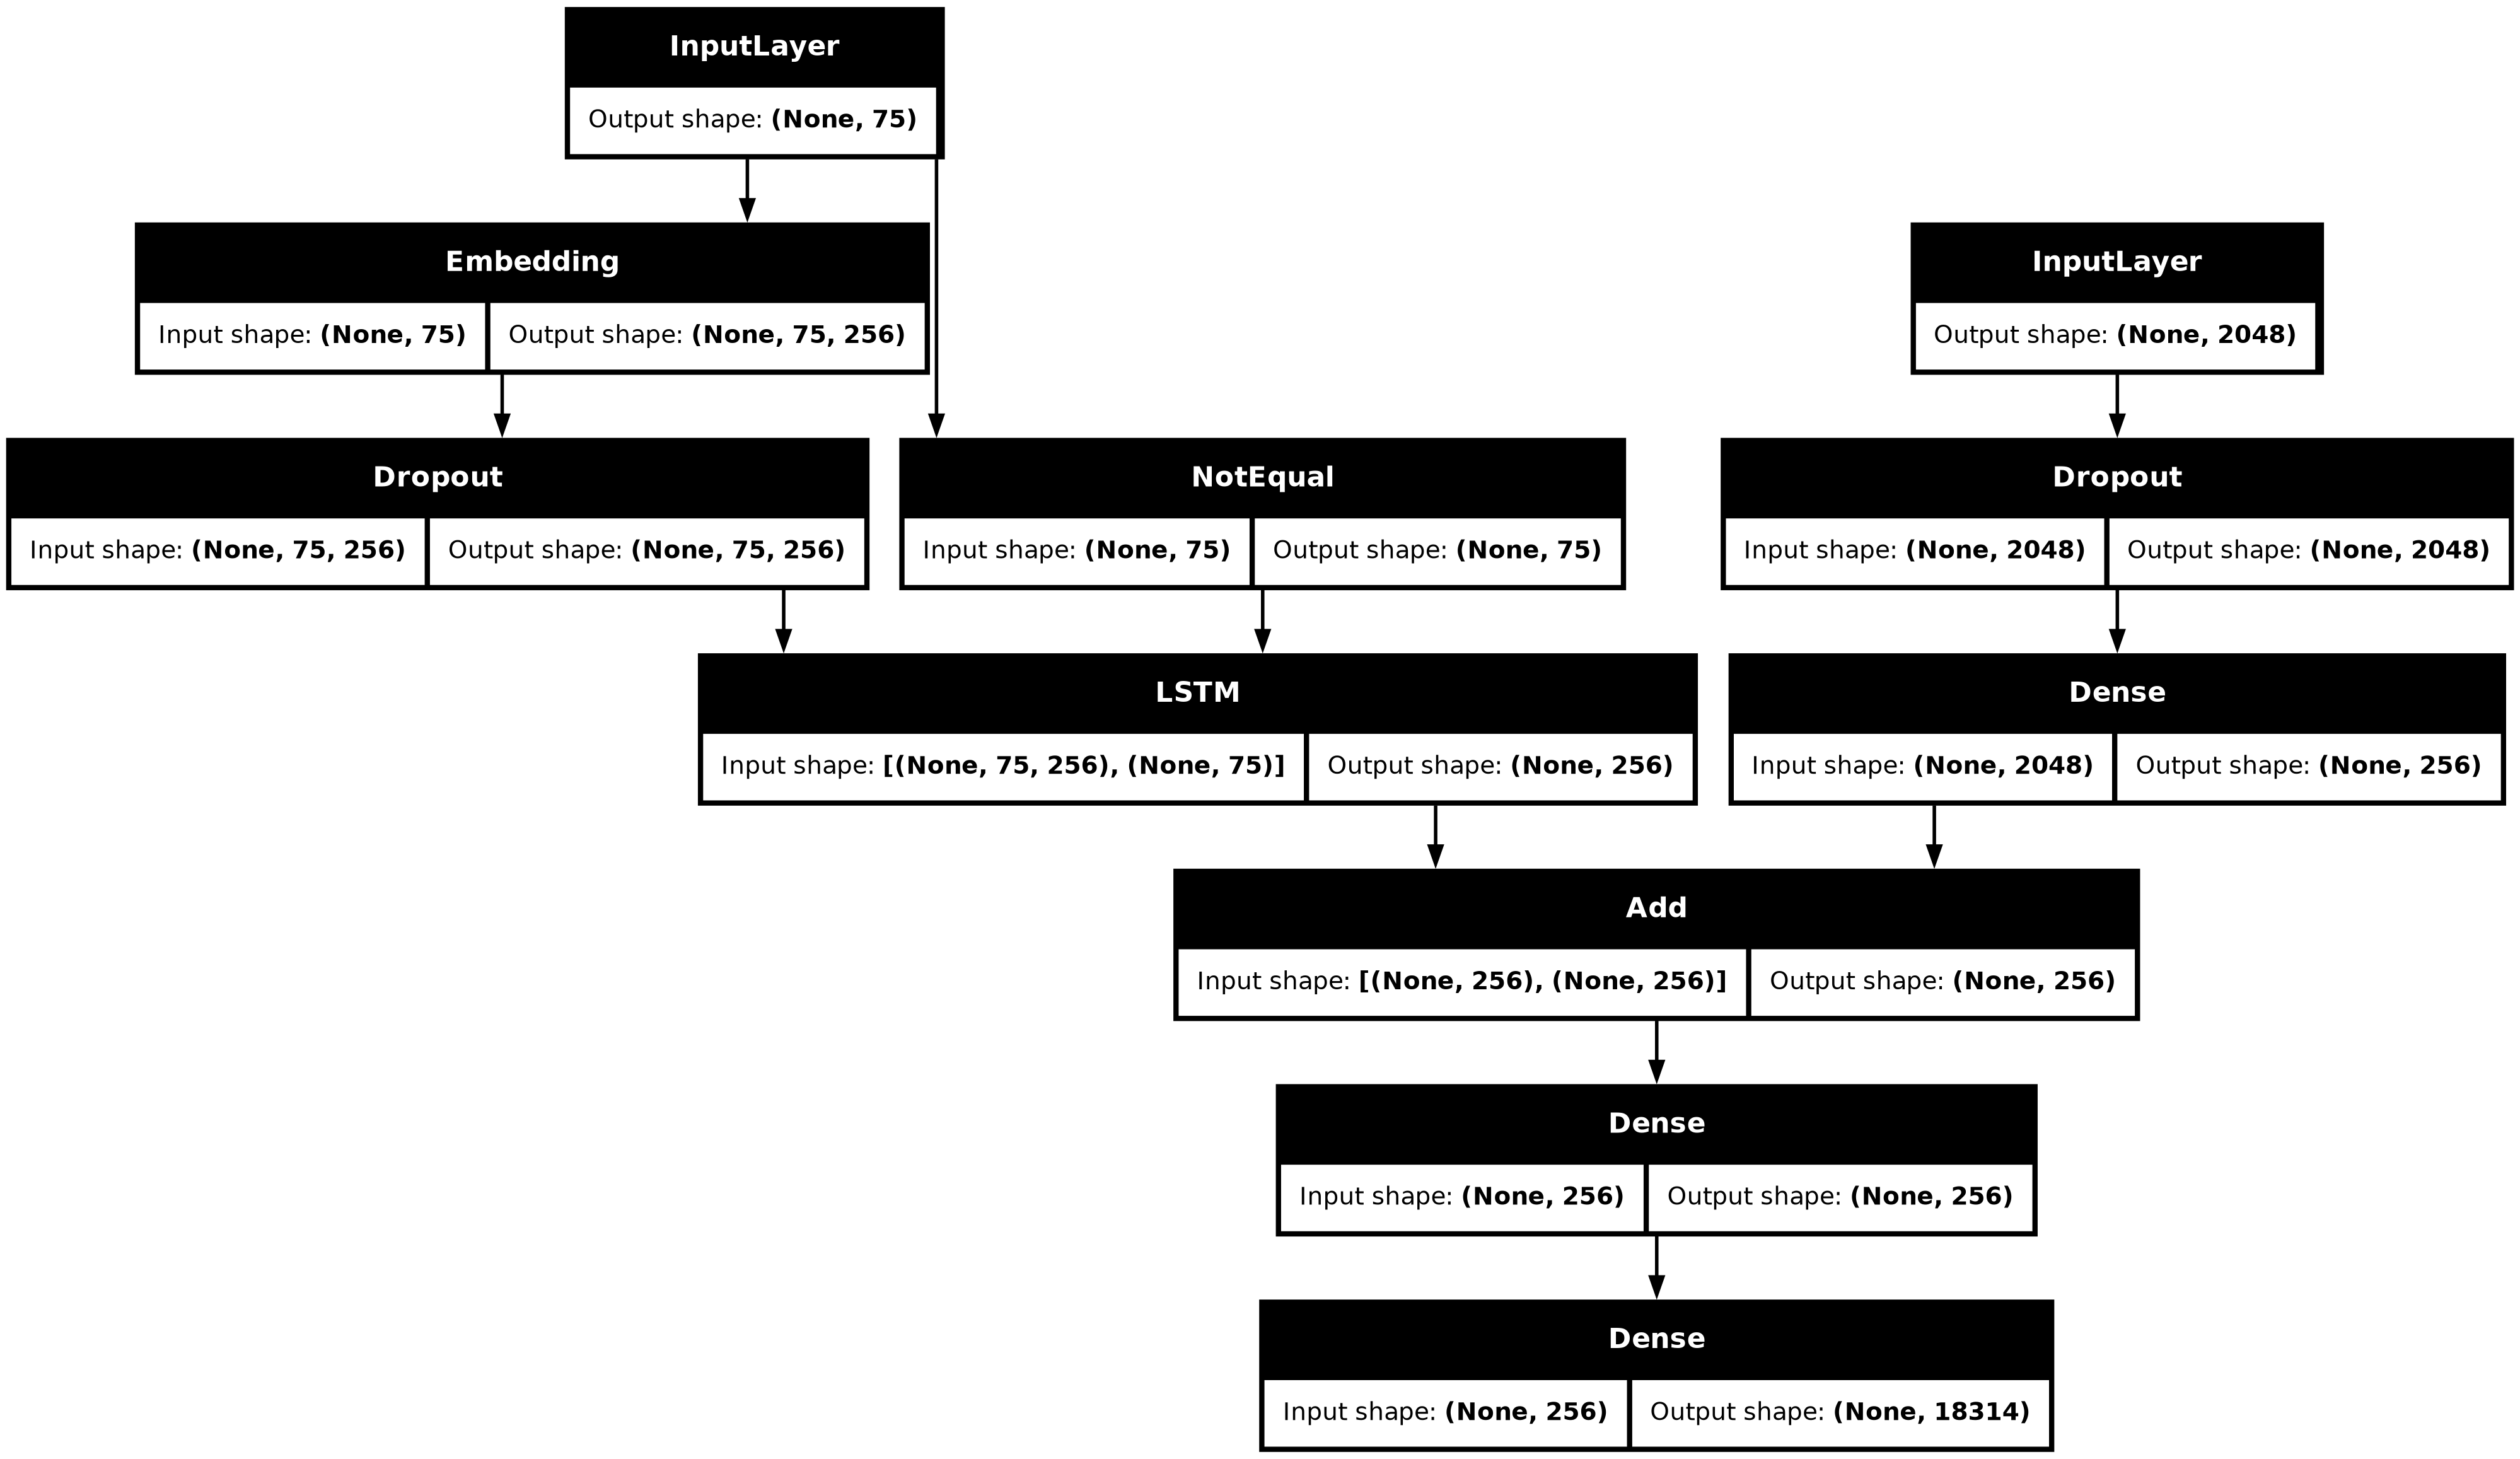

In [16]:
inputs1 = Input(shape=(2048,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

decoder1 = Add()([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
plot_model(model, show_shapes=True)


In [17]:

epochs = 30
batch_size = 32
steps = len(train) // batch_size

history = History()

for i in range(epochs):
    generator = data_generator3(train, mapping, features3, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[history])


893/893 ━━━━━━━━━━━━━━━━━━━━ 395s 439ms/step - accuracy: 0.1728 - loss: 5.2567
893/893 ━━━━━━━━━━━━━━━━━━━━ 389s 436ms/step - accuracy: 0.2822 - loss: 3.8342
893/893 ━━━━━━━━━━━━━━━━━━━━ 390s 436ms/step - accuracy: 0.3034 - loss: 3.5392
893/893 ━━━━━━━━━━━━━━━━━━━━ 390s 437ms/step - accuracy: 0.3164 - loss: 3.3586
893/893 ━━━━━━━━━━━━━━━━━━━━ 390s 436ms/step - accuracy: 0.3265 - loss: 3.2252
893/893 ━━━━━━━━━━━━━━━━━━━━ 390s 437ms/step - accuracy: 0.3360 - loss: 3.1227
893/893 ━━━━━━━━━━━━━━━━━━━━ 390s 437ms/step - accuracy: 0.3443 - loss: 3.0438
893/893 ━━━━━━━━━━━━━━━━━━━━ 389s 435ms/step - accuracy: 0.3507 - loss: 2.9830
893/893 ━━━━━━━━━━━━━━━━━━━━ 391s 438ms/step - accuracy: 0.3564 - loss: 2.9324
893/893 ━━━━━━━━━━━━━━━━━━━━ 392s 439ms/step - accuracy: 0.3611 - loss: 2.8906
893/893 ━━━━━━━━━━━━━━━━━━━━ 392s 439ms/step - accuracy: 0.3651 - loss: 2.8538
893/893 ━━━━━━━━━━━━━━━━━━━━ 391s 437ms/step - accuracy: 0.3686 - loss: 2.8244
893/893 ━━━━━━━━━━━━━━━━━━━━ 390s 437ms/step - accur

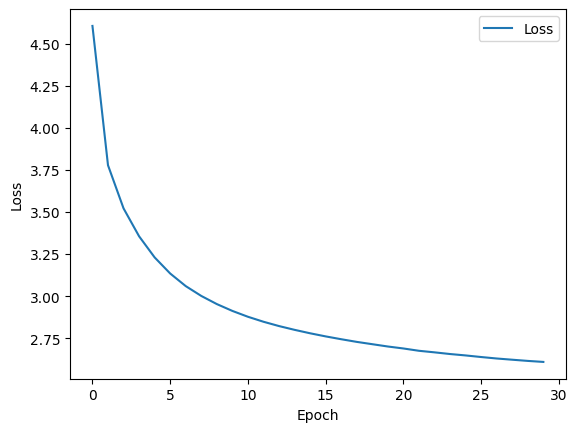

In [18]:
train_loss = history.history['loss']

plt.plot(train_loss, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


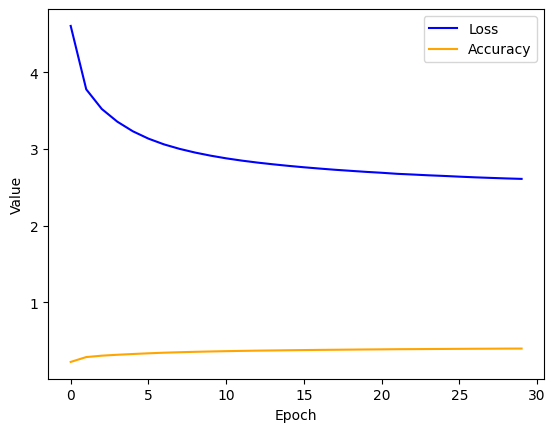

In [19]:
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

plt.plot(train_loss, label='Loss', color='blue')  
plt.plot(train_accuracy, label='Accuracy', color='orange')

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()

plt.show()


In [20]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def predict_caption3(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length, padding='post')
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text


In [21]:
def generate_caption3(image_name):
    image_id = image_name.split('.')[0]
    
    img_path = os.path.join(BASE_DIR, "Images","flickr30k_images", image_name)  
    image = Image.open(img_path)
    
    y_pred = predict_caption3(model, features3[image_id], tokenizer, max_length)
    y_pred = y_pred.replace('startseq', '').replace('endseq', '').strip()
        
    print("Generated Caption: ", y_pred)

    plt.imshow(image)
    plt.axis('off')
    plt.show()

    tts = gTTS(y_pred, lang='en')
    audio_path = f"predicted_caption_{image_name.split('.')[0]}.mp3"
    tts.save(audio_path)

    print("Click to play audio:")
    display(Audio(audio_path))
    print("\n\n")

Generated Caption:  man in blue shirt and black pants is walking down the street


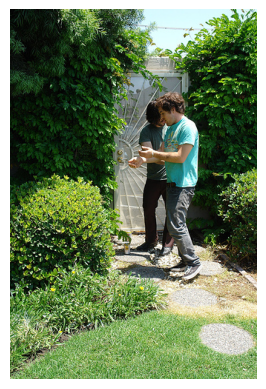

Click to play audio:





Generated Caption:  woman is blowing bubbles from bowl


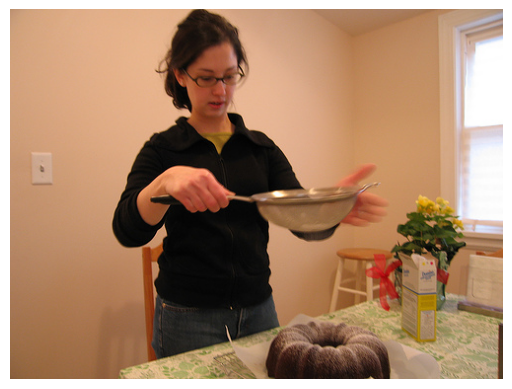

Click to play audio:





Generated Caption:  man with gauges and sunglasses is standing in front of microphone


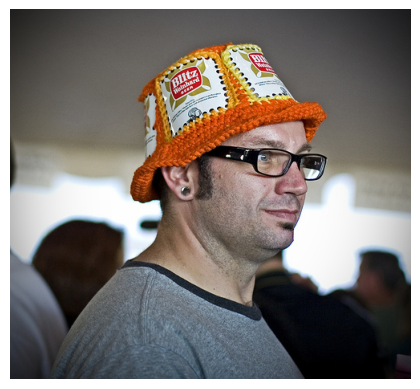

Click to play audio:





Generated Caption:  woman in black shirt and black hat is holding up her arm ands smiling at the camera


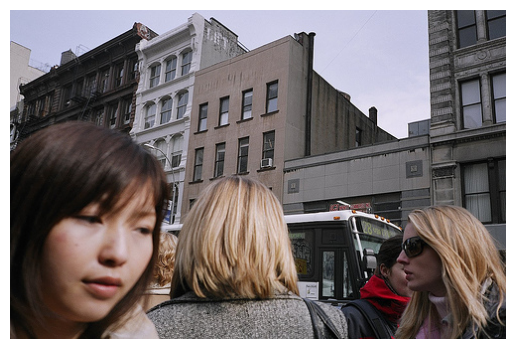

Click to play audio:


In [22]:
generate_caption3("1000092795.jpg")
generate_caption3("100207720.jpg")
generate_caption3("1007129816.jpg")
generate_caption3("100197432.jpg")

In [23]:
actual, predicted = list(), list()

for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption3(model, features3[key], tokenizer, max_length)

    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    
    actual.append(actual_captions)
    predicted.append(y_pred)

resbleu_1f = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
resbleu_2f = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
resbleu_3f = corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0))
resbleu_4f = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))

print("Final BLEU-1 for ResNet50: %f" % resbleu_1f)
print("Final BLEU-2 for ResNet50: %f" % resbleu_2f)
print("Final BLEU-3 for ResNet50: %f" % resbleu_3f)
print("Final BLEU-4 for ResNet50: %f" % resbleu_4f)


100%|██████████| 3179/3179 [35:17<00:00,  1.50it/s]


Final BLEU-1 for ResNet50: 0.534738
Final BLEU-2 for ResNet50: 0.292586
Final BLEU-3 for ResNet50: 0.173015
Final BLEU-4 for ResNet50: 0.096270


In [24]:
resnet_bleu_scores = {
    'BLEU-1': resbleu_1f,
    'BLEU-2': resbleu_2f,
    'BLEU-3': resbleu_3f,
    'BLEU-4': resbleu_4f
}

with open('resnet50_bleu_scoresf.pkl', 'wb') as f:
    pickle.dump(resnet_bleu_scores, f)

print("ResNet50 BLEU scores saved to resnet50_bleu_scores.pkl")


ResNet50 BLEU scores saved to resnet50_bleu_scores.pkl
